In [10]:
import os
import sys
# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay, RocCurveDisplay
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, SeabornFig2Grid
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming
from utils.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.ml_utils")
importlib.reload(imported_module)

<module 'utils.ml_utils' from '/home/evlasova/tcr-covid-classifier/utils/ml_utils.py'>

In [2]:
data_alpha = pd.read_csv('data/standardized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0', 'project', 'covid']).merge(
    pd.read_csv('data/standardized_usage_matrix_fmba_TRA_j.csv').drop(columns=['Unnamed: 0', 'project', 'is_test_run'])).drop(columns=['run'])
data_alpha.covid = data_alpha.covid.map({'covid': 1, 'healthy': 0})

In [3]:
X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha = split_data(data=data_alpha, y_column='covid', by='is_test_run')
best_clfs_alpha = evaluate_models(X_train_alpha, y_train_alpha, X_test_alpha, y_test_alpha, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 50, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.60

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 50, 'model__random_state': 42}
Test f1-score for the best model 0.61

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.63

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 100, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.70

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 

In [4]:
data_beta = pd.read_csv('data/standardized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0', 'project', 'covid']).merge(
    pd.read_csv('data/standardized_usage_matrix_fmba_TRB_j.csv').drop(columns=['Unnamed: 0', 'project', 'is_test_run'])).drop(columns=['run'])
data_beta.covid = data_beta.covid.map({'covid': 1, 'healthy': 0})

In [5]:
X_train_beta, y_train_beta, X_test_beta, y_test_beta = split_data(data=data_beta, y_column='covid', by='is_test_run')
best_clfs_beta = evaluate_models(X_train_beta, y_train_beta, X_test_beta, y_test_beta, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 100, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.65

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 150, 'model__random_state': 42}
Test f1-score for the best model 0.63

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Test f1-score for the best model 0.69

Started evaluating rfc
Best params for rfc: {'model__max_depth': 1, 'model__min_samples_leaf': 8, 'model__n_estimators': 50, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_sta

In [6]:
beta_initial = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRB_v.csv').drop(columns=['Unnamed: 0', 'project', 'covid']).merge(
    pd.read_csv('data/standardized_usage_matrix_fmba_TRB_j.csv').drop(columns=['Unnamed: 0', 'project', 'is_test_run'])))
alpha_initial = prepare_run_column(pd.read_csv('data/standardized_usage_matrix_fmba_TRA_v.csv').drop(columns=['Unnamed: 0', 'project', 'covid']).merge(
    pd.read_csv('data/standardized_usage_matrix_fmba_TRA_j.csv').drop(columns=['Unnamed: 0', 'project', 'is_test_run'])))
data_joint = beta_initial.merge(alpha_initial).drop(columns=['run'])
data_joint.covid = data_joint.covid.map({'covid': 1, 'healthy': 0})


In [7]:
X_train_joint, y_train_joint, X_test_joint, y_test_joint = split_data(data=data_joint, y_column='covid', by='is_test_run')
best_clfs_joint = evaluate_models(X_train_joint, y_train_joint, X_test_joint, y_test_joint, get_parameters(), scoring_function='f1_weighted', debug=True)

Started evaluating svm
Best params for svm: {'model__C': 50, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}
Test f1-score for the best model 0.61

Started evaluating ab
Best params for ab: {'model__base_estimator': DecisionTreeClassifier(max_depth=1), 'model__n_estimators': 200, 'model__random_state': 42}
Test f1-score for the best model 0.62

Started evaluating knn
Best params for knn: {'model__leaf_size': 1, 'model__n_neighbors': 3, 'model__weights': 'uniform'}
Test f1-score for the best model 0.64

Started evaluating rfc
Best params for rfc: {'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__n_estimators': 100, 'model__n_jobs': -1, 'model__oob_score': False, 'model__random_state': 42}
Test f1-score for the best model 0.69

Started evaluating mlpclassifier
Best params for mlpclassifier: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (100, 60, 30, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 4

In [8]:
all_clfs = {
     'beta': best_clfs_beta,
     'alpha': best_clfs_alpha,
     'joint': best_clfs_joint
}
X_test_data={
     'beta': X_test_beta,
     'alpha': X_test_alpha,
     'joint': X_test_joint
}
y_test_data={
     'beta': y_test_beta,
     'alpha': y_test_alpha,
     'joint': y_test_joint
}
X_train_data={
     'beta': X_train_beta,
     'alpha': X_train_alpha,
     'joint': X_train_joint
}
y_train_data={
     'beta': y_train_beta,
     'alpha': y_train_alpha,
     'joint': y_train_joint
}

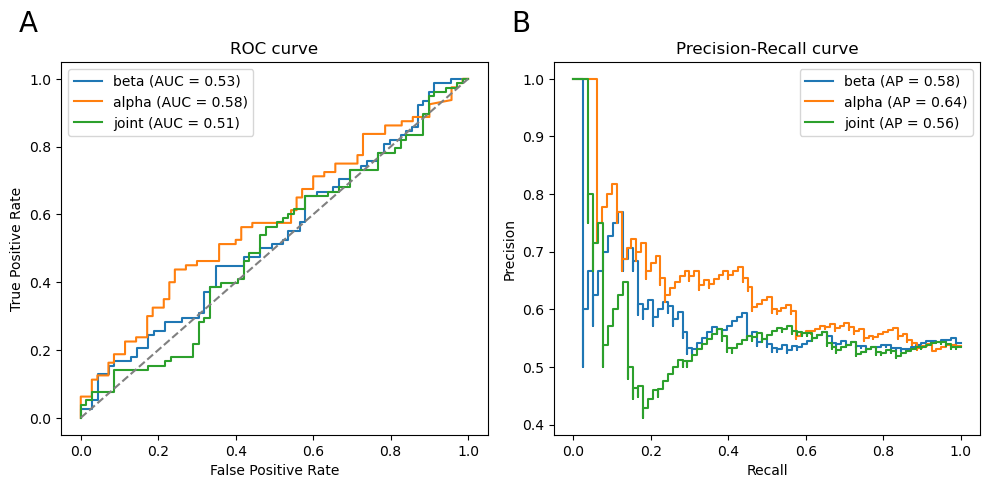

In [14]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=1, 
              ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.14

colors = {'beta': '#1f77b4', 'alpha': '#ff7f0e', 'joint': '#2ca02c'}

########################################################

ax3 = fig.add_subplot(gs[0, 0])

for key in all_clfs:
    RocCurveDisplay.from_estimator(
        all_clfs[key][0]['svm'], X_test_data[key], y_test_data[key], name=key, ax=ax3, 
        color=colors[key.split('_')[0]]
    )

ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')
ax3.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax3.legend()
ax3.set_title('ROC curve')
ax3.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

########################################################

ax11 = fig.add_subplot(gs[0, 1])

for key in all_clfs:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key][0]['svm'], X_test_data[key], y_test_data[key], name=key, ax=ax11, 
        color=colors[key.split('_')[0]]
    )

ax11.set_ylabel('Precision')
ax11.set_xlabel('Recall')
ax11.legend()
ax11.set_title('Precision-Recall curve')
ax11.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax11.transAxes,
        size=font_size)

########################################################

plt.tight_layout()
plt.savefig("figures/supp_fig9.svg")
plt.savefig("figures/supp_fig9.pdf")
plt.savefig("figures/supp_fig9.png")
plt.show()
